In [4]:
import numpy as np
import pandas as pd
import scipy
from statsmodels.stats.weightstats import *
import statsmodels.stats.multitest as smm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

## Instructions

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* **LIMIT_BAL**: размер кредитного лимита (в том числе и на семью клиента)
* **SEX**: пол клиента (1 = мужской, 2 = женский )
* **EDUCATION**: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* **MARRIAGE**: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* **AGE**: возраст в годах
* **PAY_0 - PAY_6** : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* **BILL_AMT1 - BILL_AMT6**: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* **PAY_AMT1 - PAY_AMT6**: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* **default** - индикатор невозврата денежных средств

## Задание

In [8]:
df = pd.read_csv('credit_card_default_analysis.csv', sep = ',', header = 0)
df1 = df[df.default == 0]
df2 = df[df.default == 1]
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 1. Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1)

* проверьте гипотезы: 
    * о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
    * о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 
* Значимы ли полученные результаты с практической точки зрения ?

In [3]:
df1.LIMIT_BAL.describe()

count      23364.000000
mean      178099.726074
std       131628.359660
min        10000.000000
25%        70000.000000
50%       150000.000000
75%       250000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

In [4]:
df2.LIMIT_BAL.describe()

count      6636.000000
mean     130109.656420
std      115378.540571
min       10000.000000
25%       50000.000000
50%       90000.000000
75%      200000.000000
max      740000.000000
Name: LIMIT_BAL, dtype: float64

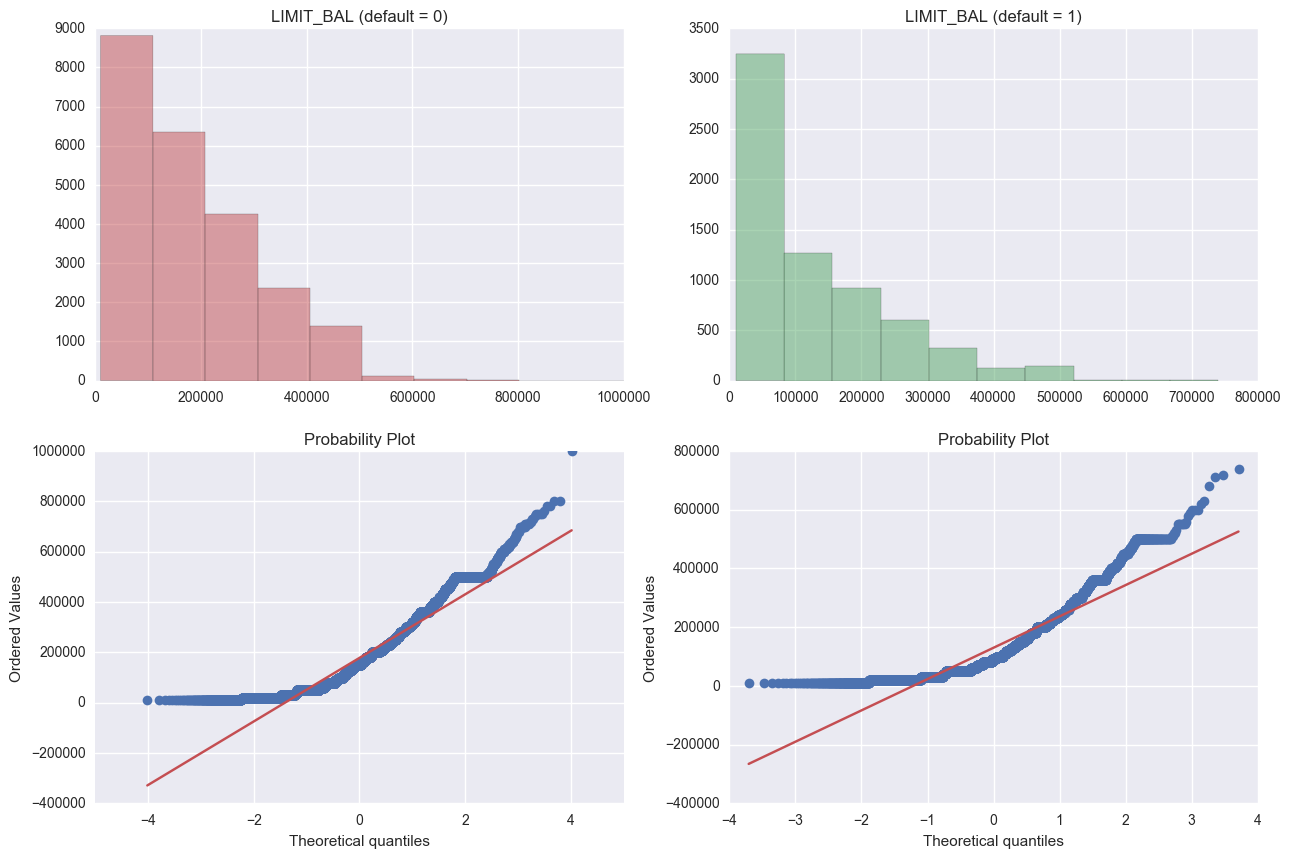

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax[0][0].hist(df1.LIMIT_BAL, bins=10, alpha = 0.5, color = 'r')
stats.probplot(df1.LIMIT_BAL, dist="norm", plot=ax[1][0])

ax[0][1].hist(df2.LIMIT_BAL, bins=10, alpha = 0.5, color = 'g')
stats.probplot(df2.LIMIT_BAL, dist="norm", plot=ax[1][1])

ax[0][0].set_title('LIMIT_BAL (default = 0)')
ax[0][1].set_title('LIMIT_BAL (default = 1)')
plt.show()

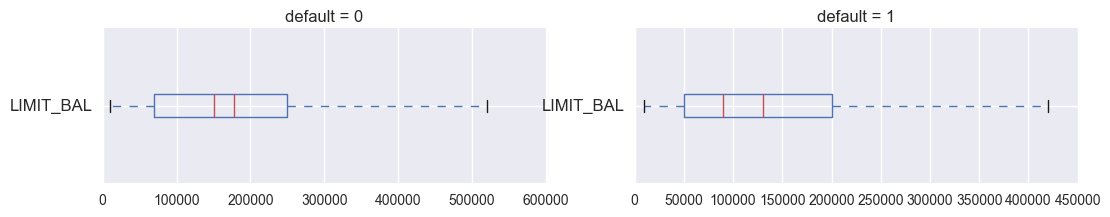

In [345]:
fig, ax = plt.subplots(1,2, figsize=(15,2))
df1.boxplot('LIMIT_BAL', ax = ax[0], vert=False, return_type='axes', meanline=True, showmeans=True, showcaps=True, 
           showbox=True, showfliers=False)
df2.boxplot('LIMIT_BAL', vert=False, return_type='axes', meanline=True, showmeans=True, showcaps=True, 
           showbox=True, showfliers=False)
ax[0].set_title('default = 0')
ax[1].set_title('default = 1')
plt.subplots_adjust(left=0.25)
plt.show()

In [356]:
np.random.seed(0)
mean_scores_0 = map(np.median, get_bootstrap_samples(df1.LIMIT_BAL.as_matrix(), 1000))
mean_scores_1 = map(np.median, get_bootstrap_samples(df2.LIMIT_BAL.as_matrix(), 1000))

print("LIMIT_BAL (default = 0) 95%% confidence interval: %s" % stat_intervals(mean_scores_0, 0.05))
print("LIMIT_BAL (default = 0) 95%% confidence interval: %s" % stat_intervals(mean_scores_1, 0.05))

# Поскольку распределения кредитного лимита в обоих случаях далеко от нормального 
# и имеет тяжелый правый хвост то используем ранговый критерий Манна-Уитни
stats.mannwhitneyu(df1.LIMIT_BAL, df2.LIMIT_BAL)

LIMIT_BAL (default = 0) 95% confidence interval: [ 150000.  150000.]
LIMIT_BAL (default = 0) 95% confidence interval: [ 80000.  90000.]


MannwhitneyuResult(statistic=59257217.5, pvalue=6.1277429091116516e-190)

* проверьте гипотезы: 
    * о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки
        * <font color='red'>Гипотеза о равенстве медианных значений против гипотезы о их неравенстве отвергается так как доверительные интервалы не пересекаются:</font>
            * **LIMIT_BAL (default = 0) 95% confidence interval: [ 150000.  150000.]**
            * **LIMIT_BAL (default = 0) 95% confidence interval: [ 80000.  90000.]**
    * о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 
        * <font color='red'>Гипотеза о равенстве распределений против гипотезы о их неравенстве отвергается на уровне значимости 0.05 так как p-value = 6.1277429091116516e-190</font>
* Значимы ли полученные результаты с практической точки зрения ?
    * <font color='red'>С практической точки зрения результаты значимы так как видно что вероятность невыплаты кредита повышается с увеличением его размера и неправильная оценка может привести к существенным финансовым потерям </font>

### 2. Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. 

Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [9]:
from statsmodels.stats.proportion import proportion_confint
df1.SEX = df1.SEX - 1
df2.SEX = df2.SEX - 1

/Users/nester.marchenko/anaconda/envs/py2/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [10]:
df1.SEX.describe()

count    23364.000000
mean         0.614150
std          0.486806
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: SEX, dtype: float64

In [11]:
df2.SEX.describe()

count    6636.000000
mean        0.567058
std         0.495520
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: SEX, dtype: float64

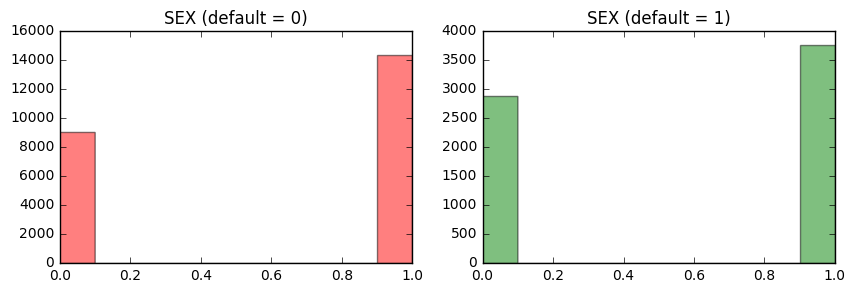

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].hist(df1.SEX, alpha = 0.5, color = 'r')
ax[1].hist(df2.SEX, alpha = 0.5, color = 'g')

ax[0].set_title('SEX (default = 0)')
ax[1].set_title('SEX (default = 1)')
plt.show()

In [25]:
df1['SEX'].value_counts() * 100 / df1.shape[0]

1    61.414997
0    38.585003
Name: SEX, dtype: float64

In [26]:
df2['SEX'].value_counts() * 100 / df2.shape[0]

1    56.705847
0    43.294153
Name: SEX, dtype: float64

#### <font color='red'>Распределение имеет биномиальный вид и поэтому выбираем Z-критерий для разности долей двух независимых выборок</font>

In [12]:
conf_interval_0 = proportion_confint(sum(df1.SEX), df1.shape[0], method = 'wilson')
conf_interval_1 = proportion_confint(sum(df2.SEX), df2.shape[0], method = 'wilson')
print("SEX (default = 0) 95%% confidence interval", conf_interval_0)
print("SEX (default = 1) 95%% confidence interval", conf_interval_1)

('SEX (default = 0) 95%% confidence interval', (0.60788973403012403, 0.62037268419107494))
('SEX (default = 1) 95%% confidence interval', (0.55510176302828174, 0.57893758196506595))


In [13]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
  proportions_diff_confint_ind(df1.SEX, df2.SEX))

print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(df1.SEX, df2.SEX)))

95% confidence interval for a difference between proportions: [0.033635, 0.060548]
p-value: 0.000000


<font color='red'>
Гипотеза о том, что гендерный состав группы людей вернувших и не вернувших кредит не отличается против того что они отличаются, отвергается так как доверительные интервалы не пересекаются:
</font>

* **SEX (default = 0) 95%% confidence interval (0.60788973403012403, 0.62037268419107494)**
* **SEX (default = 1) 95%% confidence interval (0.55510176302828174, 0.57893758196506595)**

<font color='red'>
Кроме того нулевая гипотеза отвергается на уровне значимости 0.05 так как p-value = 0
</font>


### 3. Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.

Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. 
* Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?
* Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? 
* наоборт, не отдаст долг ?

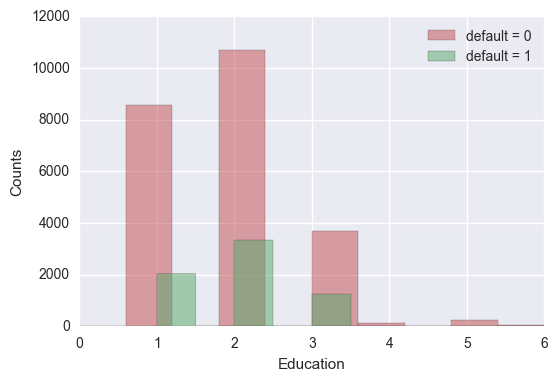

In [226]:
plt.figure(1)
plt.hist(df1.EDUCATION, bins=10, alpha = 0.5, color = 'r', label='default = 0')
plt.hist(df2.EDUCATION, bins=10, alpha = 0.5, color = 'g', label = 'default = 1')
plt.xlabel('Education')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

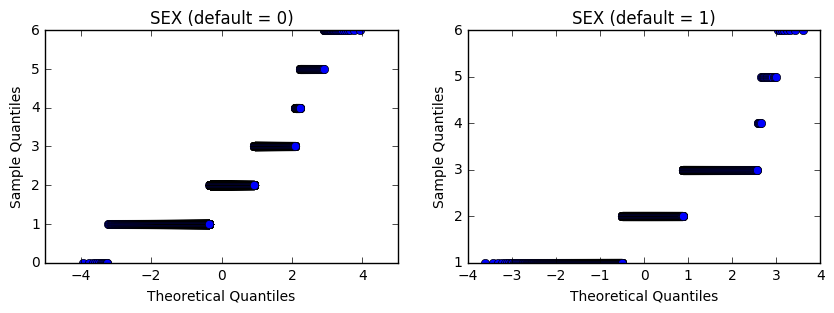

In [35]:
from statsmodels.graphics.gofplots import qqplot
fig, ax = plt.subplots(1, 2, figsize=(10,3))
qqplot(df1.EDUCATION, ax = ax[0])
qqplot(df2.EDUCATION, ax = ax[1])

ax[0].set_title('EDUCATION (default = 0)')
ax[1].set_title('EDUCATION (default = 1)')
plt.show()

In [36]:
df1.EDUCATION.value_counts()

2    10700
1     8549
3     3680
5      262
4      116
6       43
0       14
Name: EDUCATION, dtype: int64

In [37]:
df2.EDUCATION.value_counts()

2    3330
1    2036
3    1237
5      18
6       8
4       7
Name: EDUCATION, dtype: int64

#### <font color='red'>Как видно частоты значений достаточно велики для того чтобы использовать тест Кси-Квадрат</font>

In [46]:
# Getting expected frequences using scipy.stats.chi2_contingency

education = df.EDUCATION.unique()
observed_cm = np.zeros([2, len(education)])
observed_freq = df.groupby(['EDUCATION', 'default'])['default'].count()

for e, d in zip(observed_freq.index.labels[0], observed_freq.index.labels[1]):
    observed_cm[d][e] = observed_freq[e,d]
    
chi2, p, dof, expected_cm = scipy.stats.chi2_contingency(observed_cm)
cm = observed_cm - expected_cm

print('Contingency matrix for percentages of observed counts')
pd.DataFrame(observed_cm / observed_cm.sum() * 100)

Contingency matrix for percentages of observed counts


,0,1,2,3,4,5,6
0,0.046667,28.496667,35.666667,12.266667,0.386667,0.873333,0.143333
1,0.000000,6.786667,11.100000,4.123333,0.023333,0.060000,0.026667


In [47]:
print ("p-value from Chi-square test: %e" % p)

p-value from Chi-square test: 1.233263e-32


In [48]:
print('Contingency matrix for observed counts')
pd.DataFrame(observed_cm)

Contingency matrix for observed counts


,0,1,2,3,4,5,6
0,14.0,8549.0,10700.0,3680.0,116.0,262.0,43.0
1,0.0,2036.0,3330.0,1237.0,7.0,18.0,8.0


In [49]:
print('Contingency matrix for differences between observed and expected counts')
pd.DataFrame(cm)

Contingency matrix for differences between observed and expected counts


,0,1,2,3,4,5,6
0,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
1,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


In [51]:
print("""
Modified contingency matrix for differences between observed and expected counts.
""")
cm = ((observed_cm - expected_cm) / expected_cm.sum())
pd.DataFrame(cm)


Modified contingency matrix for differences between observed and expected counts.



,0,1,2,3,4,5,6
0,0.000103,0.01018,-0.007552,-0.004979,0.000674,0.001465,0.000109
1,-0.000103,-0.01018,0.007552,0.004979,-0.000674,-0.001465,-0.000109


<font color='red'>Гипотеза о том, что образование не влияет на возврат долга отрицается на уровне значимости 0.05 при p-value = 1.233263e-32</font>

* Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?
    * <font color='red'>Я бы предложил разделить разность реальных и ожидаемых значений нас сумму всех ожидаемых значений и оперировать значениями от -1 до 1. При этом интерпретируемость значений даже несколько упрощается так как мы имеем дело с пропорциями</font>
* Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? 
    * <font color='red'>При образовании 2 наибольший процент отдавших долг, и в связи с этим можно предположить что это образование является наилучшим индикатором того, что человек отдаст долг.</font>
* наоборт, не отдаст долг ?
    * <font color='red'>При образовании 0 небыло не одного случая отдачи долга и 14 случаев неотдачи</font>


### 4. Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

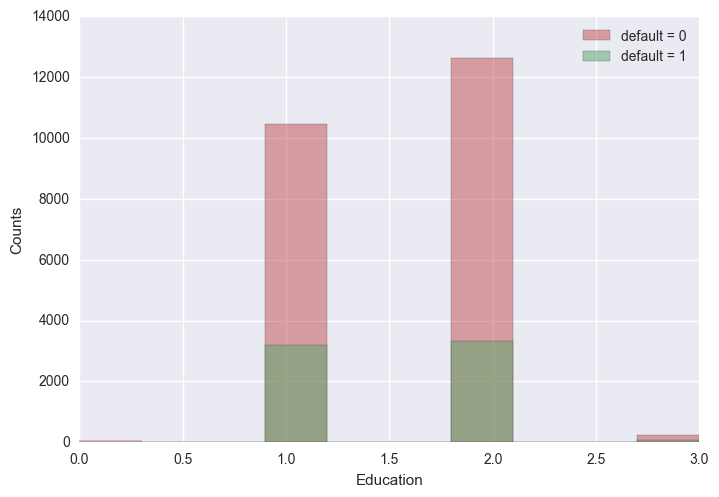

In [235]:
plt.figure(1)
plt.hist(df1.MARRIAGE, bins=10, alpha = 0.5, normed = 0, color = 'r', label='default = 0')
plt.hist(df2.MARRIAGE, bins=10, alpha = 0.5, normed = 0, color = 'g', label = 'default = 1')
plt.xlabel('Education')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

In [309]:
# Getting expected frequences using scipy.stats.contingency.expected_freq
# scipy.stats.contingency.expected_freq(observed)

marriage = df.MARRIAGE.unique()
observed_cm = np.zeros([2, len(marriage)])
observed_freq = df.groupby(['MARRIAGE', 'default'])['default'].count()
for e, d in zip(observed_freq.index.labels[0], observed_freq.index.labels[1]):
    observed_cm[d][e] = observed_freq[e,d]
    
print('Contingency matrix')
pd.DataFrame(observed_cm)

Contingency matrix


,0,1,2,3
0,49.0,10453.0,12623.0,239.0
1,5.0,3206.0,3341.0,84.0


In [52]:
df1.MARRIAGE.value_counts()

2    12623
1    10453
3      239
0       49
Name: MARRIAGE, dtype: int64

In [53]:
df2.MARRIAGE.value_counts()

2    3341
1    3206
3      84
0       5
Name: MARRIAGE, dtype: int64

#### В качестве меры выбираем коэффициент V Крамера

In [310]:
chi = stats.chi2_contingency(observed_cm)[0]
n = np.sum(observed_cm)
k = min(len(marriage), 2) - 1
V = sqrt(chi / (n * k))
print round(V, 4)

0.0345


<font color='red'>Коэффициент V Крамера больше нуля (0.0345) и поэтому можно утверждать что взаимосвязь между **MARRIAGE** и **default** есть</font>

### 5. Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: 

* о равенстве медианных значений возрастов людей 
* о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Значимы ли полученные результаты с практической точки зрения ?

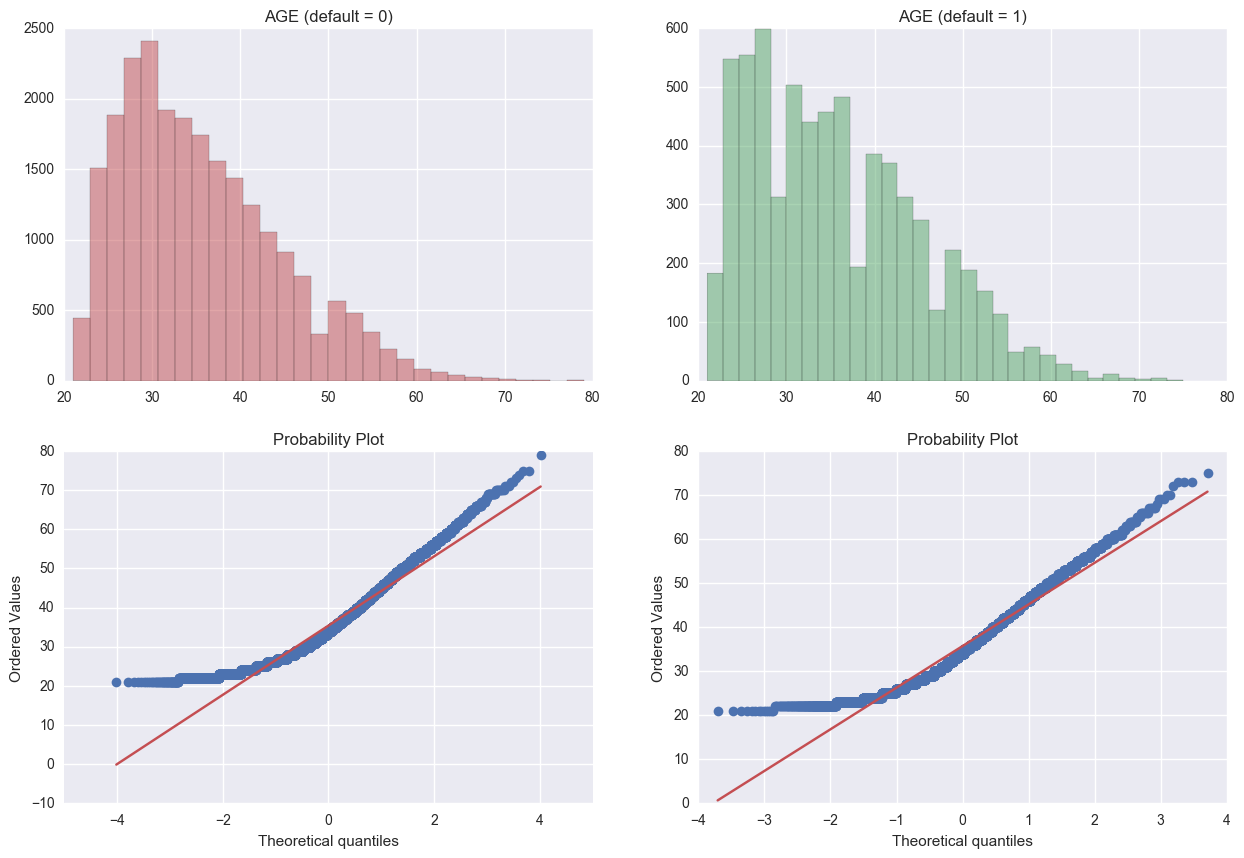

In [352]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax[0][0].hist(df1.AGE, bins=30, alpha = 0.5, color = 'r')
stats.probplot(df1.AGE, dist="norm", plot=ax[1][0])

ax[0][1].hist(df2.AGE, bins=30, alpha = 0.5, color = 'g')
stats.probplot(df2.AGE, dist="norm", plot=ax[1][1])

ax[0][0].set_title('AGE (default = 0)')
ax[0][1].set_title('AGE (default = 1)')
plt.show()

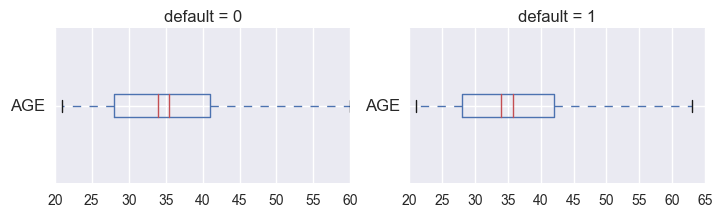

In [335]:
fig, ax = plt.subplots(1,2, figsize=(10,2))
df1.boxplot('AGE', ax = ax[0], vert=False, return_type='axes', meanline=True, showmeans=True, showcaps=True, 
           showbox=True, showfliers=False)
df2.boxplot('AGE', vert=False, return_type='axes', meanline=True, showmeans=True, showcaps=True, 
           showbox=True, showfliers=False)
ax[0].set_title('default = 0')
ax[1].set_title('default = 1')
plt.subplots_adjust(left=0.25)
plt.show()

In [355]:
np.random.seed(0)
mean_scores_0 = map(np.median, get_bootstrap_samples(df1.AGE.as_matrix(), 1000))
mean_scores_1 = map(np.median, get_bootstrap_samples(df2.AGE.as_matrix(), 1000))
delta_median_scores = map(lambda x: x[1] - x[0], zip(mean_scores_0, mean_scores_1))

print("AGE (default = 0) 95%% confidence interval: %s" % stat_intervals(mean_scores_0, 0.05))
print("AGE (default = 1) 95%% confidence interval: %s" % stat_intervals(mean_scores_1, 0.05))
print "95% confidence interval for the difference between medians:" , stat_intervals(delta_median_scores, 0.05)

AGE (default = 0) 95% confidence interval: [ 34.  34.]
AGE (default = 1) 95% confidence interval: [ 34.  35.]
95% confidence interval for the difference between medians: [ 0.  1.]


In [341]:
# Поскольку распределения кредитного лимита в обоих случаях далеко от нормального 
# и имеет тяжелый правый хвост то используем ранговый критерий Манна-Уитни
s = stats.mannwhitneyu(df1.AGE, df2.AGE, alternative = 'two-sided')

print("Checking hypothesis about distributions equality using Mann–Whitney U test:")
print('pvalue = %.4f > 0.05' % round(s[1], 4))
print("It seems like we can not reject H0 hypothesis and distributions are not shifted")

Checking hypothesis about distributions equality using Mann–Whitney U test:
pvalue = 0.3725 > 0.05
It seems like we can not reject H0 hypothesis and distributions are not shifted


проверьте гипотезы: 
* о равенстве медианных значений возрастов людей
    * <font color='red'>Гипотеза о равенстве медианных значений против гипотезы о их неравенстве не отвергается так как доверительные интервалы вложены:</font>
        * **AGE (default = 0) 95% confidence interval: [ 34.  34.]**
        * **AGE (default = 1) 95% confidence interval: [ 34.  35.]**
* о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 
    * <font color='red'>Гипотеза о равенстве распределений против гипотезы о их неравенстве не отвергается на уровне значимости 0.05 так как p-value = 0.3725</font>
* Значимы ли полученные результаты с практической точки зрения ?
    * <font color='red'>С практической точки зрения результаты наверное не имеют существенного значения и так как по всей видимости средний возраст мало влияет на способность к выплате долга</font>